In [42]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import shap


In [43]:
df_train = pd.read_csv('data/bank_train.csv')
df_test = pd.read_csv('data/bank_test.csv')
# 拔掉UUID, 客戶編號, 以及兩個分類器的結果
Y_train = df_train['Attrition_Flag']
X_train = df_train.drop(columns=['Attrition_Flag', "CLIENTNUM"])

Y_test = df_test['Attrition_Flag']
X_test = df_test.drop(columns=['Attrition_Flag', "CLIENTNUM"])


In [44]:
print("原始特徵維度：", X_train.shape)

原始特徵維度： (8101, 19)


In [45]:
categorical_cols = X_train.select_dtypes(include='object').columns
print(f"需要進行 One-Hot Encoding 的類別型欄位: {list(categorical_cols)}")

需要進行 One-Hot Encoding 的類別型欄位: ['Gender', 'Education_Level', 'Marital_Status', 'Income_Category', 'Card_Category']


In [46]:
X_train_encoded = pd.get_dummies(X_train, columns=categorical_cols, drop_first=True)
X_test_encoded = pd.get_dummies(X_test, columns=categorical_cols, drop_first=True)
print(f"One-Hot Encoding 後 Train 的特徵維度: {X_train_encoded.shape}")
print(f"One-Hot Encoding 後 Test 的特徵維度: {X_test_encoded.shape}")


One-Hot Encoding 後 Train 的特徵維度: (8101, 32)
One-Hot Encoding 後 Test 的特徵維度: (2026, 32)


In [47]:
label_encoder = LabelEncoder()
Y_train_encoded = label_encoder.fit_transform(Y_train)
Y_test_encoded = label_encoder.fit_transform(Y_test)
print(f"\n目標變數編碼對應關係: {label_encoder.classes_} -> {label_encoder.transform(label_encoder.classes_)}")


目標變數編碼對應關係: ['Attrited Customer' 'Existing Customer'] -> [0 1]


In [48]:
print(f"\n訓練集目標變數分佈:")
print(pd.Series(Y_train).value_counts(normalize=True))  
print(f"\n測試集目標變數分佈:")
print(pd.Series(Y_test).value_counts(normalize=True))   



訓練集目標變數分佈:
Attrition_Flag
Existing Customer    0.839279
Attrited Customer    0.160721
Name: proportion, dtype: float64

測試集目標變數分佈:
Attrition_Flag
Existing Customer    0.839585
Attrited Customer    0.160415
Name: proportion, dtype: float64


In [49]:
xgb_model = XGBClassifier(
    random_state=42,
    use_label_encoder=False, 
    eval_metric='logloss'    
)
xgb_model.fit(X_train_encoded, Y_train_encoded)

[19:00:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.



XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

In [50]:
y_pred = xgb_model.predict(X_test_encoded)
y_pred_proba = xgb_model.predict_proba(X_test_encoded)[:, 1] # 預測為正例 (流失) 的機率


In [51]:
print("混淆矩陣：")
print(confusion_matrix(Y_test_encoded, y_pred))


混淆矩陣：
[[ 291   34]
 [  28 1673]]


In [52]:
print("\n分類報告 (Classification Report):")
print(classification_report(Y_test_encoded, y_pred, target_names=label_encoder.classes_))


分類報告 (Classification Report):
                   precision    recall  f1-score   support

Attrited Customer       0.91      0.90      0.90       325
Existing Customer       0.98      0.98      0.98      1701

         accuracy                           0.97      2026
        macro avg       0.95      0.94      0.94      2026
     weighted avg       0.97      0.97      0.97      2026



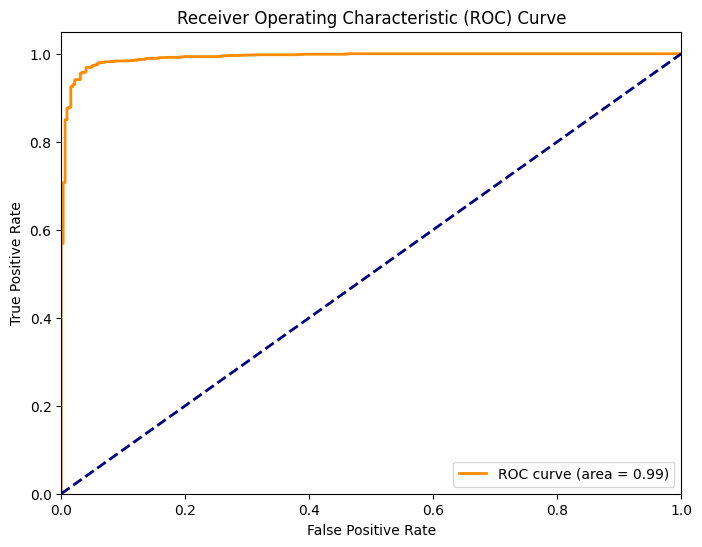

In [53]:
fpr, tpr, thresholds_roc = roc_curve(Y_test_encoded, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

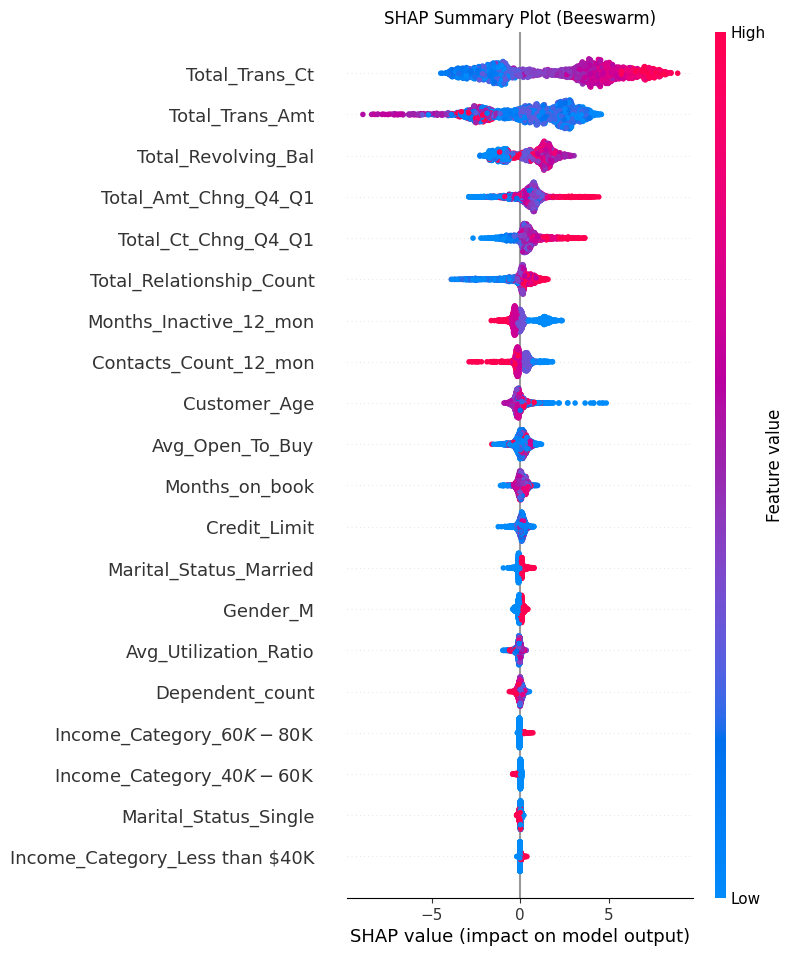

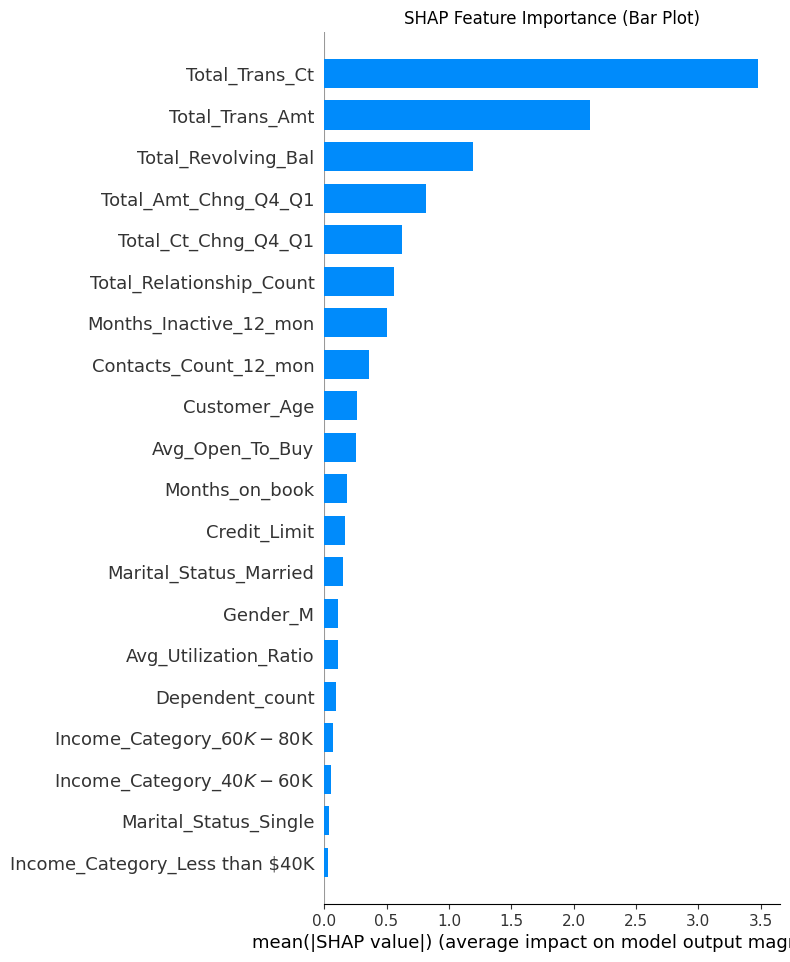

In [54]:
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_test_encoded)

plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X_test_encoded, show=False)
plt.title("SHAP Summary Plot (Beeswarm)")
plt.show()

plt.figure(figsize=(12, 6))
shap.summary_plot(shap_values, X_test_encoded, plot_type="bar", show=False)
plt.title("SHAP Feature Importance (Bar Plot)")
plt.show()

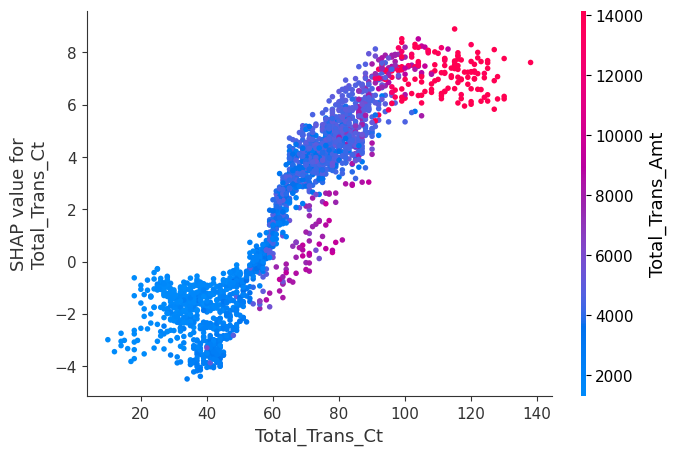

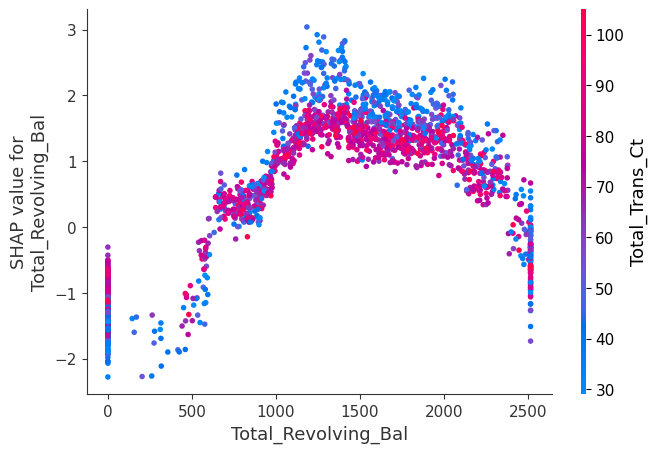

In [55]:
shap.dependence_plot("Total_Trans_Ct", shap_values, X_test_encoded, display_features=X_test_encoded)

# 繪製 'Total_Revolving_Bal' 的相依性圖
shap.dependence_plot("Total_Revolving_Bal", shap_values, X_test_encoded, display_features=X_test_encoded)

In [56]:
import numpy as np

fp_indices = np.where((y_pred == 1) & (Y_test_encoded == 0))[0]
print(f"找到 {len(fp_indices)} 個偽陽性案例 (預測留存，實際流失)")
# 為了比較，我們也提取 TN (真陰性) 案例: 真實為 Attrited (0), 預測為 Attrited (0)
tn_indices = np.where((Y_test_encoded == 0) & (y_pred == 0))[0]
print(f"總共找到 {len(tn_indices)} 個真陰性 (TN) 案例（用於比較）。\n")

找到 34 個偽陽性案例 (預測留存，實際流失)
總共找到 291 個真陰性 (TN) 案例（用於比較）。




--- 分析偽陽性案例 (索引: 4) ---
真實標籤: 0 (Attrited), 預測標籤: 1 (Existing)


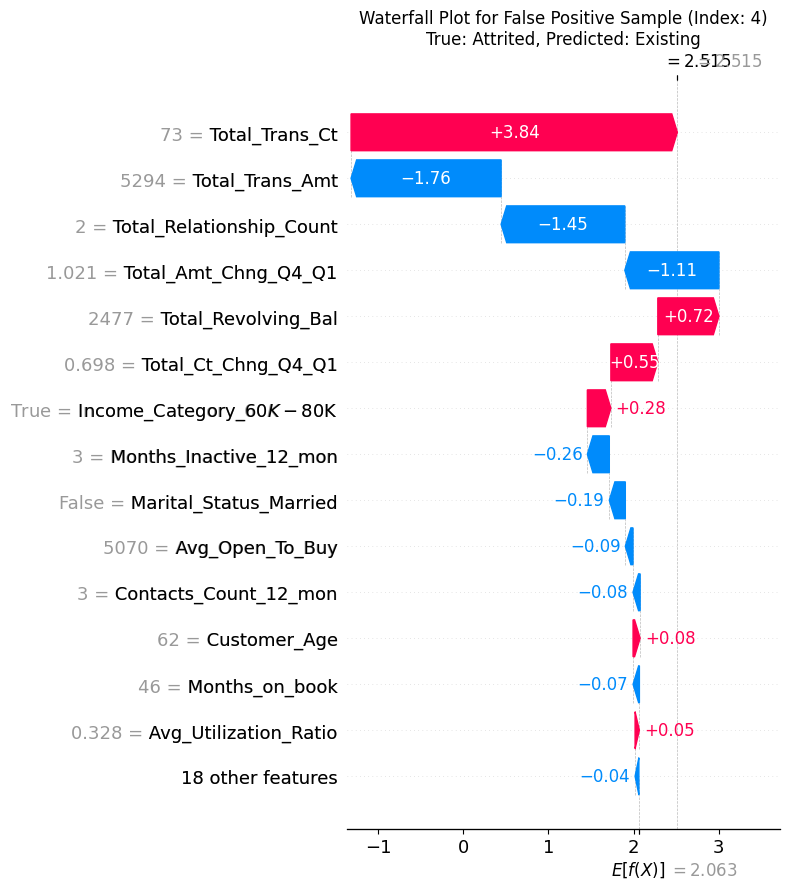

In [57]:
# 分析一個偽陽性案例 (例如第一個偽陽性案例)
if len(fp_indices) > 0:
    idx_to_analyze_fp = fp_indices[0]
    print(f"\n--- 分析偽陽性案例 (索引: {idx_to_analyze_fp}) ---")
    print(f"真實標籤: {Y_test_encoded[idx_to_analyze_fp]} (Attrited), 預測標籤: {y_pred[idx_to_analyze_fp]} (Existing)")

    shap_explanation_fp = shap.Explanation(
        values=shap_values[idx_to_analyze_fp,:],
        base_values=explainer.expected_value, # 通常是 explainer.expected_value
        data=X_test_encoded.iloc[idx_to_analyze_fp,:].values, # Waterfall 需要 .values
        feature_names=X_test_encoded.columns.tolist()
    )
    plt.figure()
    shap.plots.waterfall(shap_explanation_fp, max_display=15, show=False)
    plt.title(f"Waterfall Plot for False Positive Sample (Index: {idx_to_analyze_fp})\nTrue: Attrited, Predicted: Existing")
    plt.tight_layout()
    plt.show()


--- FP 案例中，各特徵平均 SHAP 值 (推向 Existing 的貢獻) ---
正值越大，代表該特徵平均而言越是將這些錯誤案例推向「Existing」
                           feature  mean_shap_value
7              Total_Revolving_Bal         0.304176
12             Total_Ct_Chng_Q4_Q1         0.250384
4           Months_Inactive_12_mon         0.198557
11                  Total_Trans_Ct         0.176684
2                   Months_on_book         0.098911
8                  Avg_Open_To_Buy         0.088029
1                  Dependent_count         0.043444
18   Education_Level_Post-Graduate         0.018502
20         Education_Level_Unknown         0.013906
16        Education_Level_Graduate         0.012144
6                     Credit_Limit         0.011194
23          Marital_Status_Unknown         0.010676
22           Marital_Status_Single         0.010155
5            Contacts_Count_12_mon         0.009579
27  Income_Category_Less than $40K         0.007901

--- FP 案例的 SHAP 特徵影響力 (Bar Plot) ---


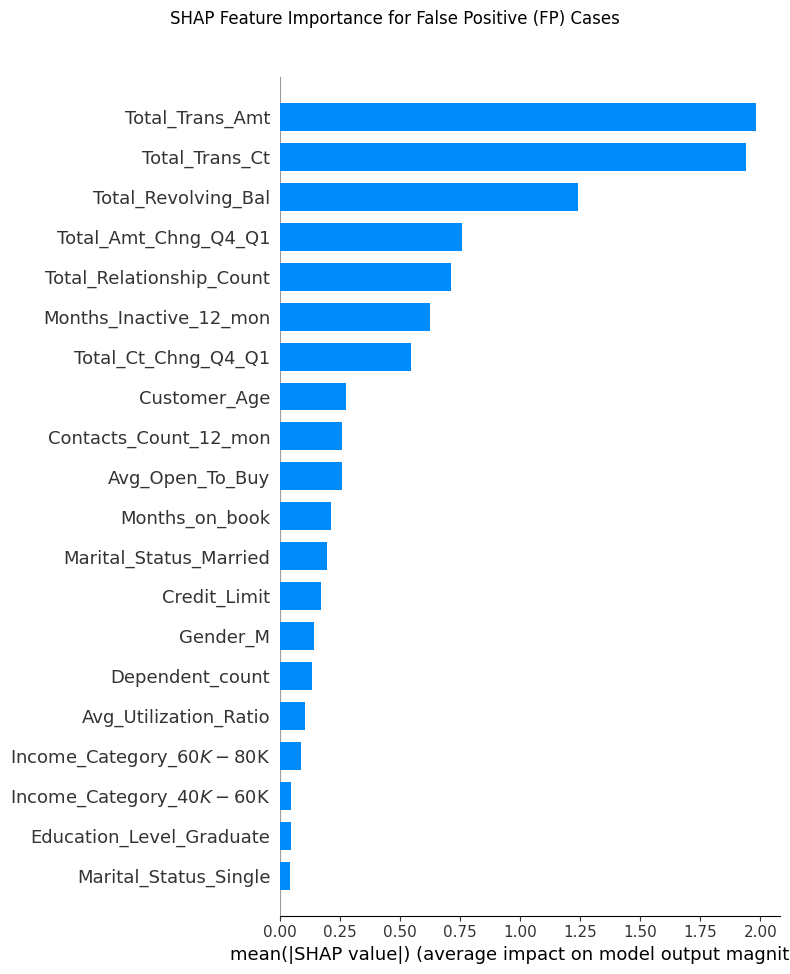

In [58]:
if len(fp_indices) > 0:
    # 提取 FP 案例的特徵數據、SHAP 值和真實標籤
    X_fp = X_test_encoded.iloc[fp_indices]
    shap_values_fp = shap_values[fp_indices, :]
    Y_fp_true = Y_test_encoded[fp_indices] # 這些都應該是 0



    # ---------------------------------------------------------------------------
    # 3. FP 案例的總體 SHAP 特徵重要性 (平均 SHAP 值)
    #    這顯示平均而言，哪些特徵將 FP 案例的預測推向了「錯誤的」Existing (正 SHAP 值)
    # ---------------------------------------------------------------------------
    if shap_values_fp.shape[0] > 0: # 確保有 FP 案例
        # 計算 FP 案例中每個特徵的平均 SHAP 值
        mean_shap_values_fp = np.mean(shap_values_fp, axis=0)
        
        # 創建一個包含特徵名稱和對應平均 SHAP 值的 DataFrame，並排序
        df_mean_shap_fp = pd.DataFrame({
            'feature': X_test_encoded.columns,
            'mean_shap_value': mean_shap_values_fp
        }).sort_values(by='mean_shap_value', ascending=False)

        print("\n--- FP 案例中，各特徵平均 SHAP 值 (推向 Existing 的貢獻) ---")
        print("正值越大，代表該特徵平均而言越是將這些錯誤案例推向「Existing」")
        print(df_mean_shap_fp.head(15)) # 顯示貢獻最大的前15個

        print("\n--- FP 案例的 SHAP 特徵影響力 (Bar Plot) ---")
        plt.figure(figsize=(10,8))
        shap.summary_plot(shap_values_fp, X_fp, plot_type="bar", show=False, max_display=20)
        # 獲取當前 Figure，然後修改其標題 (summary_plot 本身不直接接受 title)
        fig = plt.gcf()
        fig.suptitle("SHAP Feature Importance for False Positive (FP) Cases", y=1.02) # y調整標題位置
        plt.tight_layout() # 自動調整子圖參數以給定一個緊湊的佈局
        plt.show()



In [ ]:
if len(tn_indices) > 0:
    shap_values_tn = shap_values[tn_indices, :]
    X_tn = X_test_encoded.iloc[tn_indices] # 確保 X_tn 也已提取

    # 計算 TN 案例中每個特徵的平均 SHAP 值
    mean_shap_values_tn = np.mean(shap_values_tn, axis=0)
    
    # 創建一個包含特徵名稱和對應平均 SHAP 值的 DataFrame，並排序
    # 這次我們可能對「負值最大」（最強烈推向 Attrited）的特徵感興趣
    df_mean_shap_tn = pd.DataFrame({
        'feature': X_test_encoded.columns,
        'mean_shap_value': mean_shap_values_tn
    }).sort_values(by='mean_shap_value', ascending=True) # ascending=True 使負值最大的排前面

    print("\n--- TN 案例中，各特徵平均 SHAP 值 (推向 Attrited 的貢獻) ---")
    print("負值越大，代表該特徵平均而言越是將這些正確案例推向「Attrited」")
    print(df_mean_shap_tn.head(15)) # 顯示最強烈推向 Attrited 的前15個特徵

    print("\n--- TN 案例的 SHAP 特徵影響力 (Bar Plot) ---")
    plt.figure(figsize=(10,8))
    shap.summary_plot(shap_values_tn, X_tn, plot_type="bar", show=False, max_display=20)
    fig = plt.gcf()
    fig.suptitle("SHAP Feature Importance for True Negative (TN) Cases", y=1.02)
    plt.tight_layout()
    plt.show()
    
else:
    print("在測試集中沒有找到任何真陰性 (TN) 案例可供分析。")

In [60]:
fp_probabilities = y_pred_proba[fp_indices]

# 創建一個包含 FP 索引和對應機率的 DataFrame 以便排序
df_fp_confidence = pd.DataFrame({
    'fp_index': fp_indices,
    'probability_existing': fp_probabilities
})

# 按機率降序排序
df_fp_confidence_sorted = df_fp_confidence.sort_values(by='probability_existing', ascending=False)
print(f"--- 分析模型「錯得最自信」的  FP 案例 ---")
print(df_fp_confidence_sorted)
print("-" * 50)

--- 分析模型「錯得最自信」的  FP 案例 ---
    fp_index  probability_existing
9        389              0.999865
26      1375              0.999609
24      1196              0.996881
17       757              0.994606
19       831              0.994219
7        290              0.976546
12       499              0.973423
5        232              0.961720
18       758              0.961495
20       876              0.956389
0          4              0.925176
27      1407              0.919604
31      1770              0.914848
2        147              0.866273
15       664              0.866177
14       600              0.861368
3        181              0.840328
32      1832              0.806126
22       977              0.792954
29      1645              0.700810
1         10              0.686365
13       580              0.673636
4        217              0.669543
28      1593              0.651311
25      1319              0.642371
33      2002              0.593965
11       421              0

In [67]:
# 選取 Top N 案例進行分析 (例如 Top 3 或 Top 5)
# N_top_fps = min(20, len(df_fp_confidence_sorted)) # 最多看5個，或實際FP數量

N_top_fps = 34

top_n_fp_cases = df_fp_confidence_sorted.head(N_top_fps)

In [ ]:
top_n_fp_cases = df_fp_confidence_sorted.head(N_top_fps)
print(f"--- 分析模型「錯得最自信」的 Top {N_top_fps} 個 FP 案例 ---")
print(top_n_fp_cases)
print("-" * 50)

# ---------------------------------------------------------------------------
# 4. 為選取的 Top N FP 案例繪製並分析 Waterfall Plots
# ---------------------------------------------------------------------------
label_map = {0: "Attrited", 1: "Existing"} # 用於標籤顯示

for i in range(len(top_n_fp_cases)):
    case_info = top_n_fp_cases.iloc[i]
    idx_to_analyze = int(case_info['fp_index']) # 轉換為整數索引
    confidence = case_info['probability_existing']
    
    actual_label = Y_test_encoded[idx_to_analyze]
    predicted_label = y_pred[idx_to_analyze] # 這應該是 1

    print(f"\n正在分析 Top {i+1} FP 案例 (原始索引: {idx_to_analyze})")
    print(f"模型預測為 'Existing' 的機率: {confidence:.4f}")
    print(f"真實標籤: {label_map[actual_label]} ({actual_label}), 預測標籤: {label_map[predicted_label]} ({predicted_label})")

    # Waterfall Plot
    shap_explanation_sample = shap.Explanation(
        values=shap_values[idx_to_analyze,:],
        base_values=explainer.expected_value,
        data=X_test_encoded.iloc[idx_to_analyze,:].values,
        feature_names=X_test_encoded.columns.tolist()
    )
    plt.figure(figsize=(10,8))
    shap.plots.waterfall(shap_explanation_sample, max_display=20, show=False)
    plt.title(f"Waterfall Plot for HIGH CONFIDENCE FP (Index: {idx_to_analyze}, P(Existing)={confidence:.2f})\nTrue: {label_map[actual_label]}, Predicted: {label_map[predicted_label]}", fontsize=12)
    plt.tight_layout()
    plt.show()


--- 繪製 Top 5 重要特徵的 SHAP 相依性圖 ---


<Figure size 1000x600 with 0 Axes>

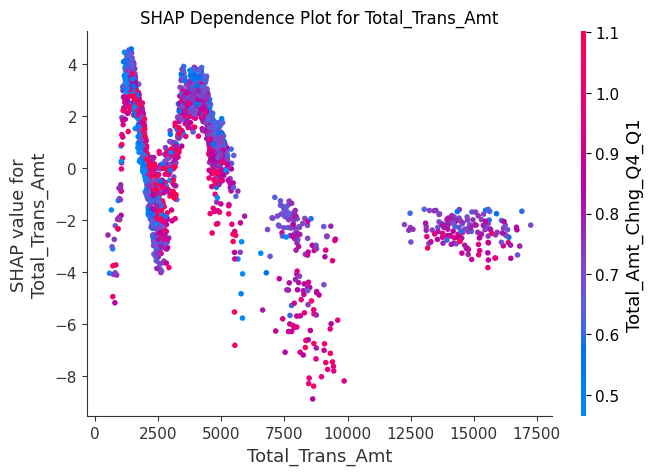

<Figure size 1000x600 with 0 Axes>

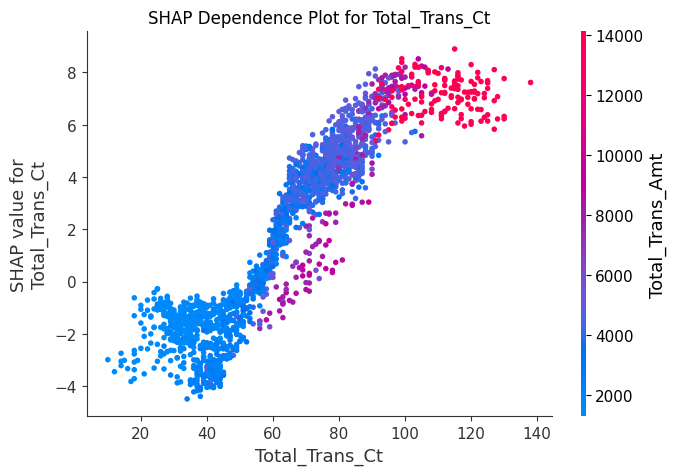

<Figure size 1000x600 with 0 Axes>

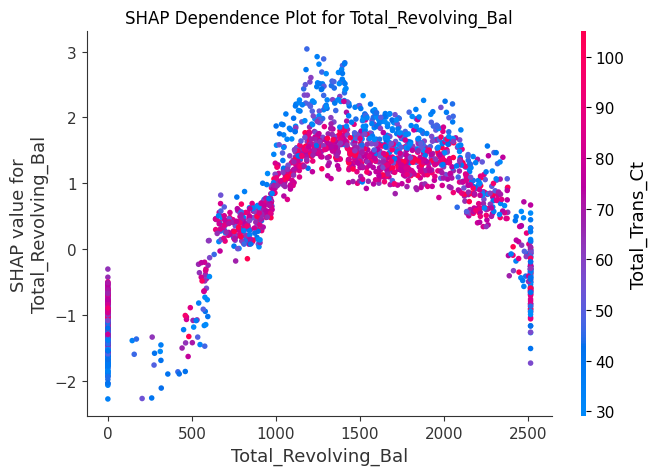

<Figure size 1000x600 with 0 Axes>

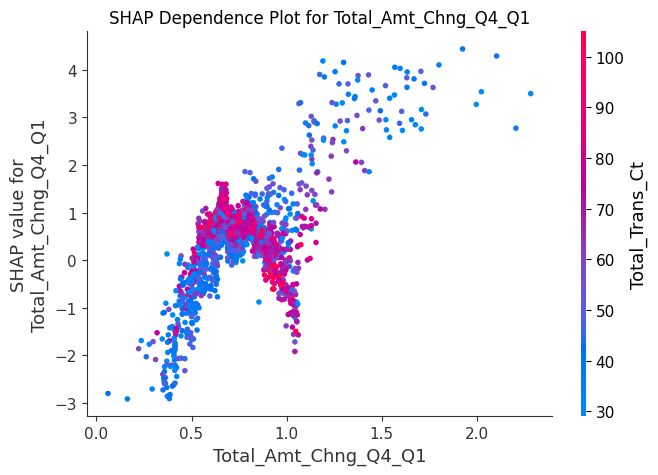

<Figure size 1000x600 with 0 Axes>

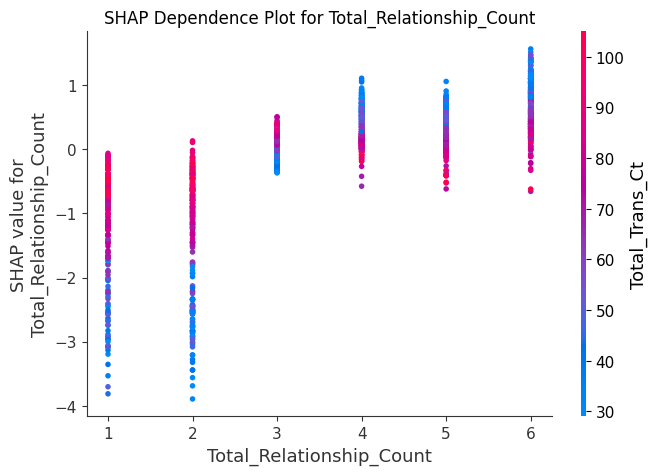

<Figure size 1000x600 with 0 Axes>

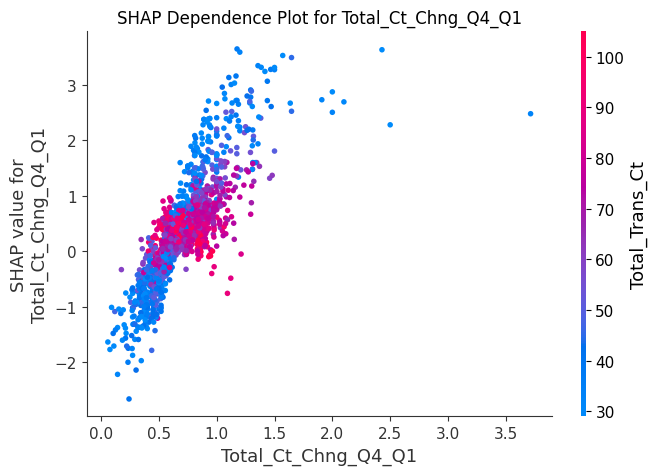

<Figure size 1000x600 with 0 Axes>

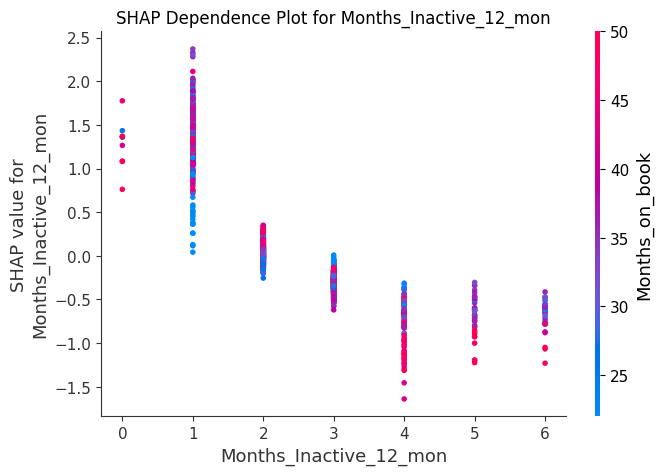

In [66]:

# 全局最重要的前五個特徵 (根據您的圖 image_829f39.png)
top_features = [
    'Total_Trans_Amt',
    'Total_Trans_Ct',
    'Total_Revolving_Bal',
    'Total_Amt_Chng_Q4_Q1',
    'Total_Relationship_Count',
    'Total_Ct_Chng_Q4_Q1',
    'Months_Inactive_12_mon',
    
]

print("\n--- 繪製 Top 5 重要特徵的 SHAP 相依性圖 ---")
for feature_name in top_features:
    if feature_name in X_test_encoded.columns:
        plt.figure(figsize=(10, 6))
        shap.dependence_plot(
            feature_name,
            shap_values,
            X_test_encoded,
            display_features=X_test_encoded,
            interaction_index="auto", # 讓 SHAP 自動選擇交互作用最強的特徵
            show=False
        )
        plt.title(f"SHAP Dependence Plot for {feature_name}")
        plt.show()
    else:
        print(f"警告：特徵 '{feature_name}' 不在 X_test_encoded 的欄位中。")

<Figure size 1000x600 with 0 Axes>

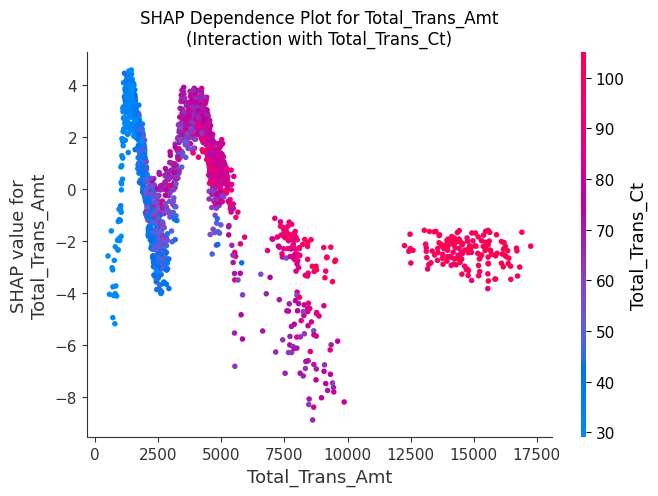

In [64]:
plt.figure(figsize=(10, 6))
shap.dependence_plot(
    "Total_Trans_Amt",
    shap_values,
    X_test_encoded,
    display_features=X_test_encoded,
    interaction_index="Total_Trans_Ct",  # 指定交互特徵
    show=False
)
plt.title(f"SHAP Dependence Plot for Total_Trans_Amt\n(Interaction with Total_Trans_Ct)")
plt.show()